Arrival at 0.11350804143617954
Transaction: 3
Inventory position 18
Arrival at 0.745017691524894
Transaction: 4
Inventory position 64
Arrival at 0.8880195298197313
Transaction: 1
Inventory position 63
Arrival at 1.1123574903542235
Transaction: 3
Inventory position 60
Arrival at 1.1421417914034984
Transaction: 3
Inventory position 57
Arrival at 1.1888969229175548
Transaction: 2
Inventory position 55
Arrival at 1.1977781174706386
Transaction: 1
Inventory position 54
Arrival at 1.231839200071179
Transaction: 1
Inventory position 53
Arrival at 1.2632393767736962
Transaction: 1
Inventory position 52
Arrival at 1.4479856301085612
Transaction: 1
Inventory position 51
Arrival at 1.5567490056676387
Transaction: 3
Inventory position 48
Arrival at 1.827044298690714
Transaction: 2
Inventory position 46
Arrival at 1.860637734094029
Transaction: 1
Inventory position 45
Arrival at 1.9059605478281052
Transaction: 2
Inventory position 43
Arrival at 1.9113991485804898
Transaction: 3
Inventory position 4

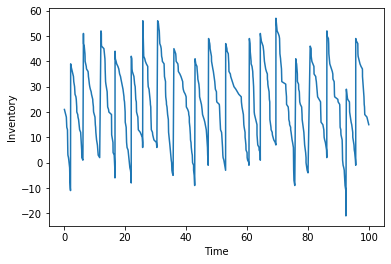

In [80]:
# Simulation of an (s,Q) inventory system

import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

reorderpoint = 20
lotsize = 50
customers = 1000
leadtime = 2
runtime = 100
arrivals = 5
transaction = 2 #compound poisson process, =1=>pure poisson
fixcost = 100
holdingcost = 1
penaltycost = 10

ip = reorderpoint+1
inventorycount = 0
demandcount = 0
lastevent = 0
orders = 0
stockout = 0
filled = 0
x = []
y = []

def source(env,inventory,backorder):
    for i in range(customers):
        t = random.expovariate(arrivals)
        yield env.timeout(t) # Wait until interarrival time has passed   
        c = customer(env,inventory,backorder)
        env.process(c) # Add new customer process
        print("Arrival at " +str(env.now))

def customer(env,inventory,backorder):
    global ip, orders, filled, inventorycount, demandcount, lastevent
    inventorycount = inventorycount+inventory.level*(env.now-lastevent)
    lastevent = env.now      
    x.append(env.now)
    y.append(inventory.level-backorder.level)
    tasize = np.random.geometric(1/transaction)
    demandcount = demandcount+tasize
    print("Transaction: "+str(tasize))
    if inventory.level >= tasize:
      filled = filled+tasize 
      yield inventory.get(tasize)
    else: 
      filled = filled+inventory.level
      yield backorder.put(tasize-inventory.level)
      if inventory.level > 0:
        yield inventory.get(inventory.level)
    ip = ip-tasize
    print("Inventory position "+str(ip))
    if ip < reorderpoint:
      o = replenish(env,inventory,backorder)
      env.process(o) # Add a new replenishment process
      orders = orders+1  
        
def replenish(env,inventory,backorder):
    global ip, stockout, inventorycount, lastevent
    ip = ip+lotsize
    yield env.timeout(leadtime)
    inventorycount = inventorycount+inventory.level*(env.now-lastevent)
    lastevent = env.now    
    x.append(env.now)
    y.append(inventory.level-backorder.level)
    if backorder.level > 0:
        stockout = stockout+1
    print("Delivery at "+str(env.now))
    if backorder.level >= lotsize:
       yield backorder.get(lotsize)
    elif backorder.level > 0:
       yield inventory.put(lotsize-backorder.level) 
       yield backorder.get(backorder.level) 
    else: yield inventory.put(lotsize)

#environment: 2 functions run parallel        
env = simpy.Environment()

inventory = simpy.Container(env, init=reorderpoint+1, capacity=1000)
backorder = simpy.Container(env, init=0, capacity=1000)
env.process(source(env,inventory,backorder))
env.run(until=runtime)

print("Orders: "+str(orders))
print("Stockouts: "+str(stockout))
print("Average inventory: "+str(inventorycount/runtime))
print("Cycle availability: "+str(1-stockout/orders))
print("Fillrate: "+str(filled/demandcount))
print("Average Cost: "+str((orders*fixcost+stockout*penaltycost+inventorycount*holdingcost)/runtime))
plt.xlabel("Time")
plt.ylabel("Inventory")
plt.plot(x,y)
plt.show()